In [1]:
#Import necessary libraries
from __future__ import print_function #Python 2.7 compatibility

%load_ext autoreload
%autoreload 2

from copy import deepcopy
import math
import numpy as np
import os 
import sys
import time

import rslaser.optics.wavefront as rswf
import srwlib
from srwlib import srwl

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.ndimage
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}

In [2]:
# Example with imperfect mirrors:  https://github.com/ochubar/SRW/blob/master/env/work/srw_python/SRWLIB_Example09.py

#Create Gaussian source
#Create Gaussian wavefront
##Create Gaussian wavefront
#sigr: requested RMS beam size [m]
#propLen: propagation length required by SRW to create numerical Gaussian [m]
#pulseE: energy per pulse [J]
#poltype: polarization type (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
#phE: photon energy [eV]
#sampFact: sampling factor to increase mesh density

sigrW = 1e-3 #RMS beam size at waist [m]
propLen = 15  ##20 #Propagation length in initial creation [m]
pulseE = .001 #Total energy of pulse
poltype = 1
phE = 1.54 #Energy in eV 
sampFact = 10 ##25, 44, 60
constConvRad = 1.23984186e-06/(4*3.1415926536)  ##conversion from energy to 1/wavelength
rmsAngDiv = constConvRad/(phE*sigrW)
print("RMS beam divergence at waist: %s radians" %(rmsAngDiv))
mx = 0
my = 0

#create a Gaussian wavefront in SRW
wfr0 = rswf.createGsnSrcSRW(sigrW,propLen,pulseE,poltype,phE,sampFact,mx,my)
print("Initial wavefront calculated on a grid of %d x %d points" %(wfr0.mesh.nx,wfr0.mesh.ny))

RMS beam divergence at waist: 6.406719502292485e-05 radians
Initial wavefront calculated on a grid of 168 x 168 points


Size of initial wavefront data array (coordinate): (168, 168)


Text(0.5, 1.0, 'Intensity at Waist')

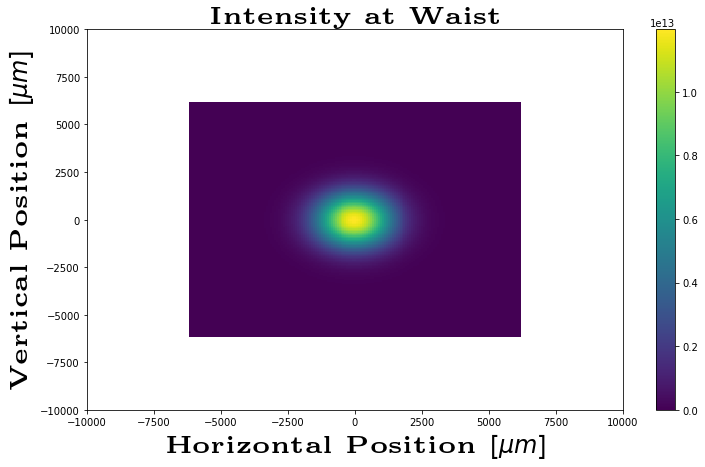

In [3]:
# Plot initial wavefront
##Initial wfr calculation
arIinit = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity
##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-1e4,1e4)
ax.set_xlim(-1e4,1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity at Waist',**hfontLarge)

In [4]:
#Export initial intensity distribution to file
fname="InitialWavefrontArray.txt"
np.shape(arIinit2D)
np.savetxt(fname, arIinit2D, fmt='%.18e')
print("Initial Wavefront written to file %s",fname)

Initial Wavefront written to file %s InitialWavefrontArray.txt


In [5]:
#Create parameters for beamline
L=10 #Length to mirror [m]
f=L/2 #Effective focal length of mirror [m]
strDataFolderName = 'slope_errors'
strMirSurfHeightErrInFileName = 'mirror1.dat'

In [6]:
wfr1 = deepcopy(wfr0)
#srwl.ResizeElecField(wfr1, 'c', [1, 5, 15, 5, 15])

wfrsizef=(wfr1.mesh.nx*wfr1.mesh.ny)

optBL = rswf.createReflectionOffFocusingMirrorBL(L,f,strDataFolderName,strMirSurfHeightErrInFileName)
#optBL=createBL1to1(L,dfof=0)
start_time = time.time()
srwl.PropagElecField(wfr1, optBL)
print("Propagation time: %s seconds" %(round((time.time() - start_time),5)))

Propagation time: 0.63166 seconds


Text(0.5, 1.0, 'Intensity after propagation')

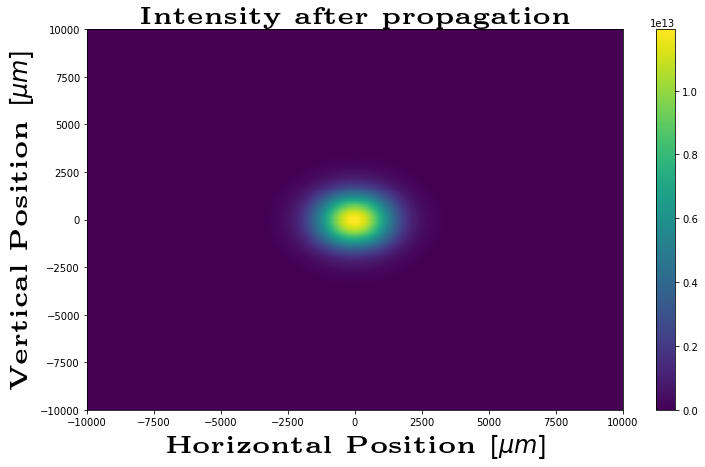

In [7]:
#Extract final array and export to numpy array
arIf = srwlib.array('f', [0]*wfr1.mesh.nx*wfr1.mesh.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIf, wfr1, 6, 0, 3, wfr1.mesh.eStart, 0, 0) #extracts intensity
##Reshaping electric field data from flat to 2D array
arIf2D = np.array(arIf).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')

xvalsf02=np.linspace(wfr1.mesh.xStart,wfr1.mesh.xFin,wfr1.mesh.nx)
yvalsf02=np.linspace(wfr1.mesh.yStart,wfr1.mesh.yFin,wfr1.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIf2D, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-1e4,1e4)
ax.set_xlim(-1e4,1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity after propagation',**hfontLarge)

Propagation time: 0.20622 seconds


Text(0.5, 1.0, 'Intensity after propagation')

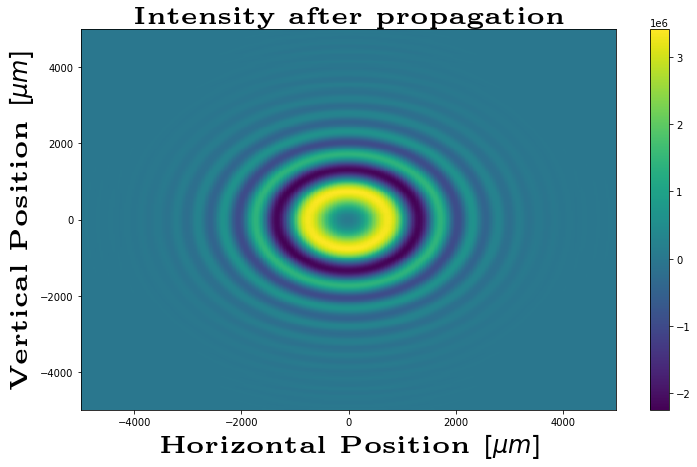

In [8]:
# Propagate with a rotation ABCD matrix
theta = np.pi/4
Aval = np.cos(theta)
Bval = np.sin(theta)
Cval = -np.sin(theta)
Dval = np.cos(theta)

wfr2 = deepcopy(wfr1)
wfrsizef = (wfr2.mesh.nx*wfr2.mesh.ny)
ABCDBL = rswf.createABCDbeamline(Aval,Bval,Cval,Dval)

start_time = time.time()
srwl.PropagElecField(wfr2, ABCDBL)
print("Propagation time: %s seconds" %(round((time.time() - start_time),5)))

# Extract final array and export to numpy array
arIf2 = srwlib.array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny)                  # flat array for 2D intensity data
srwl.CalcIntFromElecField(arIf2, wfr2, 6, 5, 3, wfr1.mesh.eStart, 0, 0)   # extract real part of E-field

# Reshaping electric field data from flat to 2D array
arIf22D = np.array(arIf2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')

xvalsf02=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
yvalsf02=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIf22D, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-5e3,5e3)
ax.set_xlim(-5e3,5e3)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity after propagation',**hfontLarge)